<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Color spaces and image processing</p>

### En esta práctica, trabajaremos con los espacios de color RGB y HSV, veremos la diferencia de cada uno de ellos e implementaremos un detector de bordes que probaremos con imágenes en ambos espacios.

### Primero, buscaremos segmentar una imagen a partir de su espacio de  color. Para eso utilizaremos dos funciones de opencv principalmente: "bitwise_and" e "inRange".

In [2]:
import cv2 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.colors import hsv_to_rgb

### convierte las imágenes de tu dataset al espacio RGB (ojo que openCV trabaja por defecto en BGR)

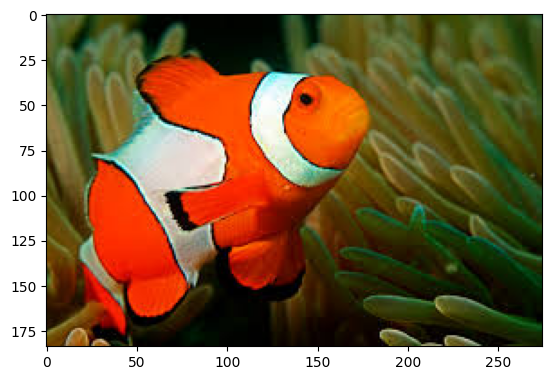

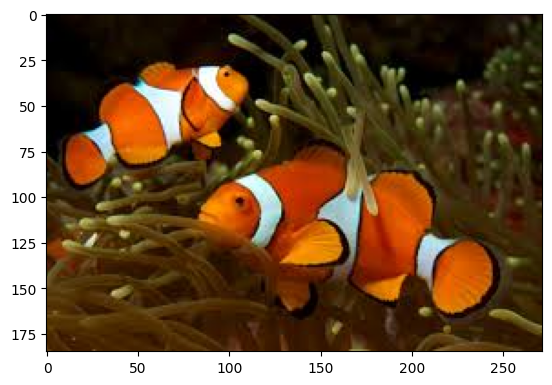

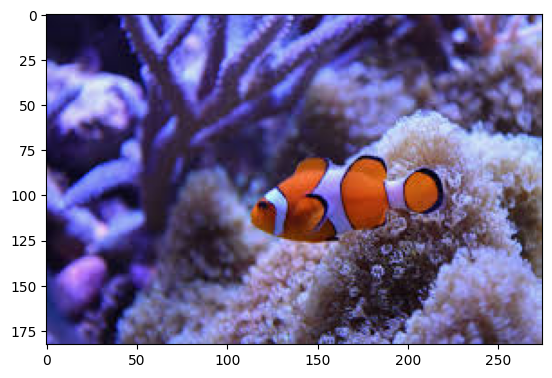

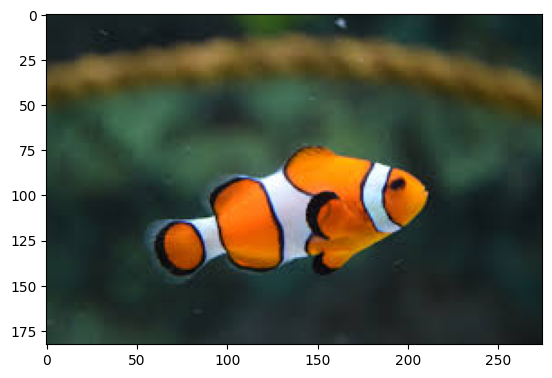

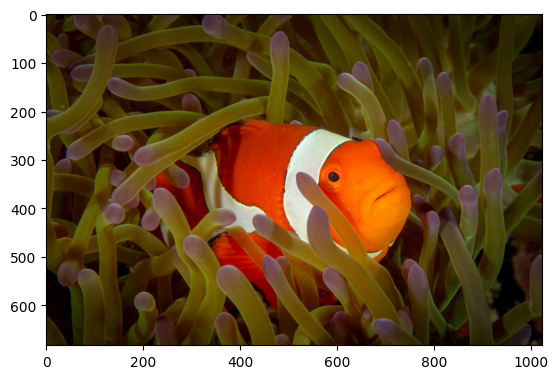

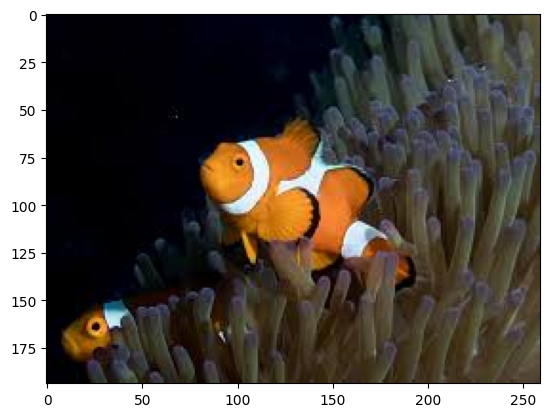

In [3]:
imgs = []
for i in range(0, 6):
    img = cv2.imread('images/{}.jpg'.format(i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    plt.figure()
    plt.imshow(img)
    plt.show()
    

### Trabajaremos de momento con la imagen 0 de nuestro dataset. Filtra la imagen entre los dos tonos siguientes de naranja usando las funciones "inRange" y "bitwise_and" de opencv

naranja_claro = (1, 190, 200)

naranja_oscuro = (18, 255, 255)

### Ojo, para poder segmentar la parte de la imagen que está entre estos colores deberás transformarla a un espacio de color donde la crominancia y la intensidad estén separados

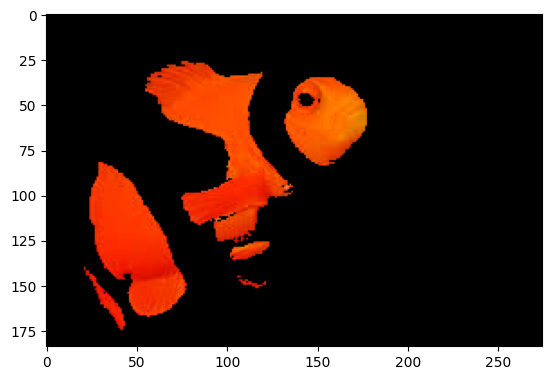

In [4]:
naranja_claro = (1, 190, 200)
naranja_oscuro = (18, 255, 255)
img_n = imgs[0]

# transformamos la imagen a HSV para poder separar la crominancia de la intensidad
img_hsv = cv2.cvtColor(img_n, cv2.COLOR_RGB2HSV)

# creamos una máscara con los valores de naranja que queremos detectar
mask_n = cv2.inRange(img_hsv, naranja_claro, naranja_oscuro)

# aplicamos la máscara a la imagen original
img_masked_n = cv2.bitwise_and(img_n, img_n, mask=mask_n)

# mostramos la imagen con la máscara aplicada
plt.figure()
plt.imshow(img_masked_n)
plt.show()

### Haz lo mismo pero ahora segmenta solo las lineas blancas de la imagen 0 de nuestro dataset

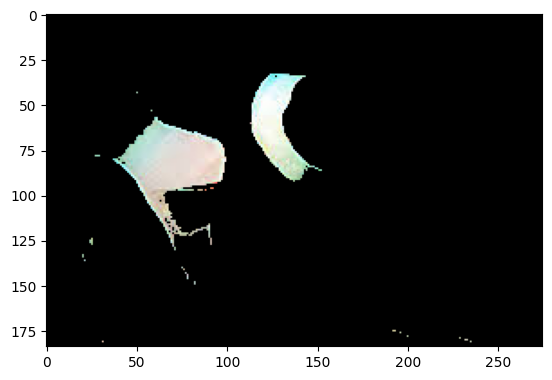

In [5]:
# blancos en hls
blanco_1 = (0,170,0)
blanco_2 = (255, 255, 255)
img_b = imgs[0]

# transformamos la imagen a HLS para poder separar la luminancia de la intensidad
img_hls = cv2.cvtColor(img_b, cv2.COLOR_RGB2HLS)

# creamos una máscara con los valores de blanco que queremos detectar
mask_b = cv2.inRange(img_hls, blanco_1, blanco_2)

# aplicamos la máscara a la imagen original
img_masked_b = cv2.bitwise_and(img_b, img_b, mask=mask_b)

# mostramos la imagen
plt.figure()
plt.imshow(img_masked_b)
plt.show()

### Junta tu implementación y deberías ser capaz de obtener una imagen donde solo se segmente el pez payaso (parte naranja y parte blanca) en tu imagen 0 del dataset. Plotea los resultados

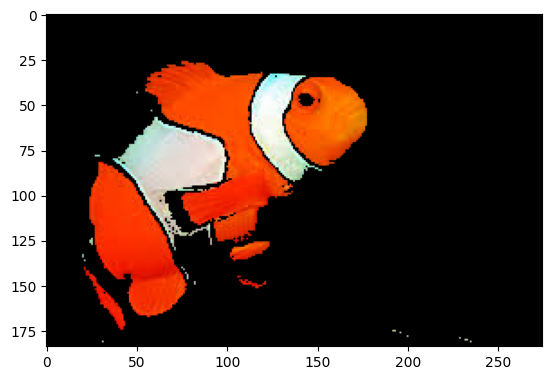

In [6]:
# juntamos las dos mascaras
pez = cv2.bitwise_or(img_masked_n, img_masked_b)
plt.figure()
plt.imshow(pez)
plt.show()


### Generaliza tu implementación y aplícala a todas las imágenes del dataset. Pega tus resultados en tu informe.

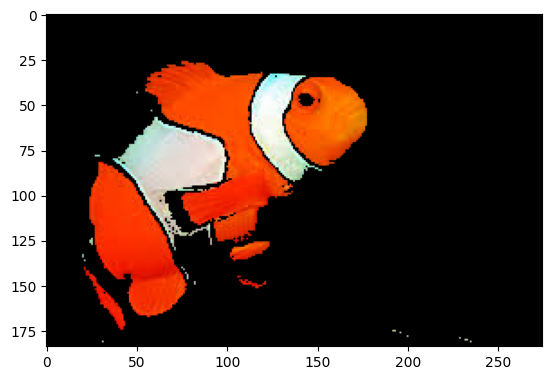

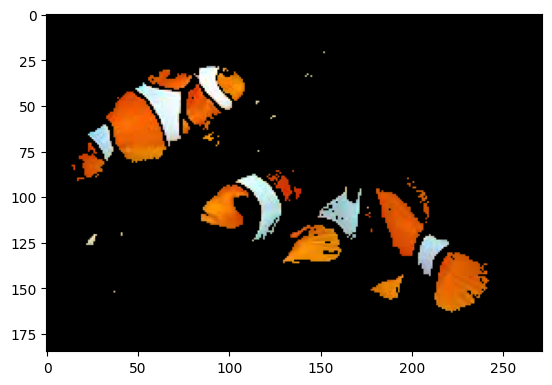

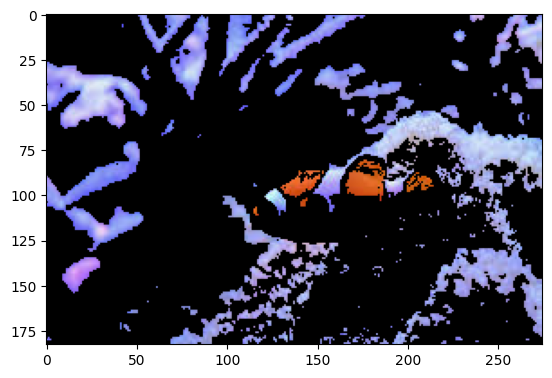

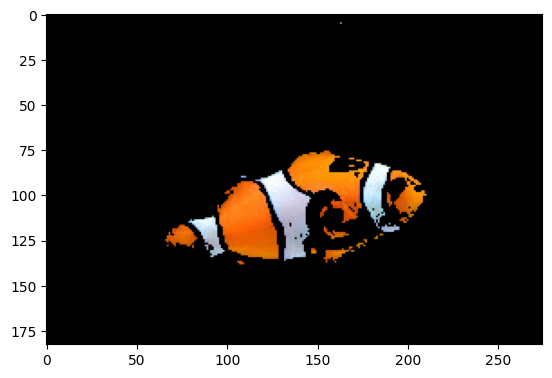

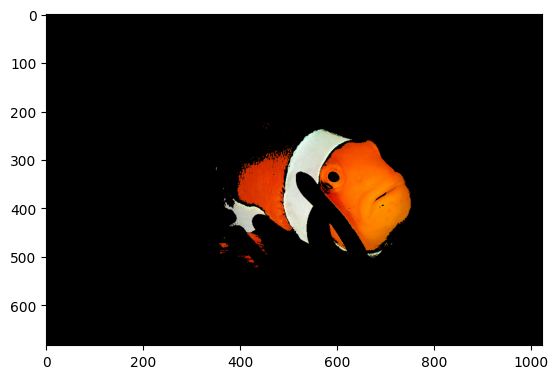

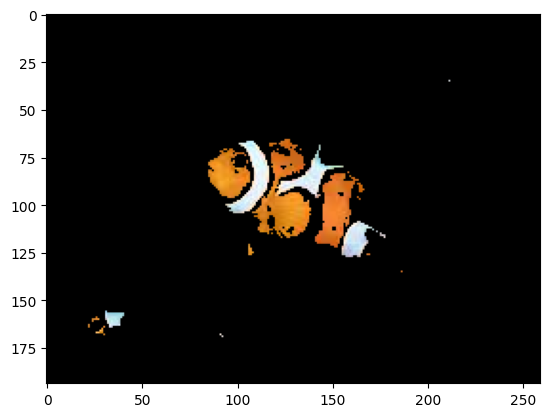

In [7]:
def get_orange(img): # devuelve la mascara de la parte naranja de la imagen
    naranja_claro = (1, 190, 200)
    naranja_oscuro = (18, 255, 255)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_n = cv2.inRange(img_hsv, naranja_claro, naranja_oscuro)
    img_masked_n = cv2.bitwise_and(img, img, mask=mask_n)
    return img_masked_n

def get_white(img): # devuelve la mascara de la parte blanca de la imagen
    blanco_1 = (0,170,0)
    blanco_2 = (255, 255, 255)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    mask_b = cv2.inRange(img_hls, blanco_1, blanco_2)
    img_masked_b = cv2.bitwise_and(img, img, mask=mask_b)
    return img_masked_b


for i in range(0, 6):
    img = imgs[i]
    img_n = get_orange(img)
    img_b = get_white(img)
    pez = cv2.bitwise_or(img_n, img_b)
    plt.figure()
    plt.imshow(pez)

## Parte 2: Image processing

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

### Implementa una función "convolution" con dos entradas: imagen y el kernel. Asume un Kernel 3x3 y 
### aplica padding para que la convolción pueda tener lugar en los pixeles de los extremos

In [9]:
def convolution(image, kernel):
    # Volteamos el kernel
    kernel = np.flipud(np.fliplr(kernel))

    # añadimos padding
    pad = int((kernel.shape[0] - 1) / 2)
    shape = (image.shape[0] + 2 * pad, image.shape[1] + 2 * pad, image.shape[2])
    image_padded = np.zeros(shape)
    image_padded[pad:-pad, pad:-pad, :] = image

    # aplicamos la convolucion
    conv = np.zeros(image.shape)
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            for z in range(image.shape[2]):
                conv[y, x, z] = (kernel * image_padded[y: y + kernel.shape[0], x: x + kernel.shape[1], z]).sum()

    return conv


def normalize(image):
    image_norm = image / image.max()
    image_norm[image_norm < 0] = 0
    return image_norm


### Ahora implementaremos un método de edge detection llamado Sobel. Éste se basa en un filtro derivativo y usaremos el filtro 

filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

### Recuerda por la teoría, que el método Sobel devuelve dos matrices, una de la convolución de la imagen de entrada con el filtro original y otra que es el resultado de aplicar el filtro original traspuesto.

In [10]:
def togray(image, image_format):
    if image_format == 'RGB':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        img = img[:, :, 2]
    elif image_format == 'HSV':
        img = image[:, :, 2]
    elif image_format == 'HLS':
        img = cv2.cvtColor(image, cv2.COLOR_HLS2HSV)
        img = img[:, :, 2]
    elif image_format == 'BGR':
        img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        img = img[:, :, 2]
    else:
        img = image
    img = np.expand_dims(img, axis=2) 
    return img  


def sobel_edge_detection(image, filter):
    # eje x
    gradient_x = convolution(image, filter)
    gradient_x = normalize(gradient_x)

    # volteamos el filtro
    gradient_x2 = convolution(image, np.fliplr(filter))
    gradient_x2 = normalize(gradient_x2)

    gradient_x = gradient_x + gradient_x2
    gradient_x[gradient_x > 255] = 25

    # eje y
    gradient_y = convolution(image, filter.T)
    gradient_y = normalize(gradient_y)

    # volteamos el filtro
    gradient_y2 = convolution(image, np.flipud(filter.T))
    gradient_y2 = normalize(gradient_y2)

    gradient_y = gradient_y + gradient_y2
    gradient_y[gradient_y > 255] = 255

    # sumamos los gradientes
    gradient_magnitude = gradient_x + gradient_y
    gradient_magnitude[gradient_magnitude > 255] = 255

    return gradient_x , gradient_y, gradient_magnitude
 

### Aplica tu edge detector a la imagen 0 del dataset

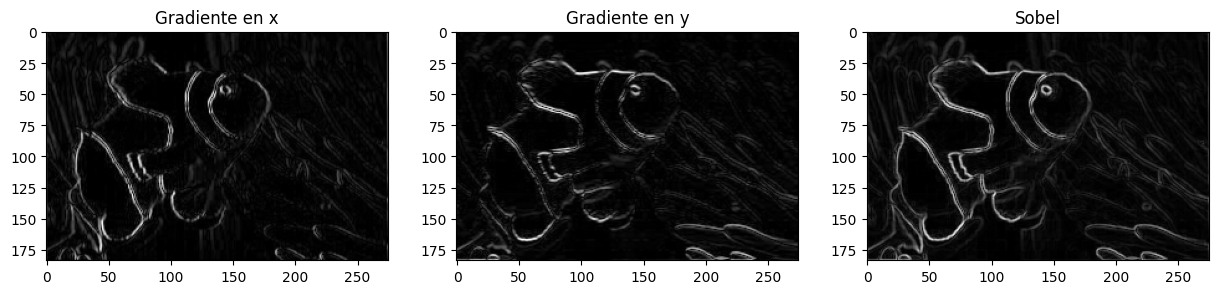

In [11]:
img = imgs[0]
img = togray(img, 'RGB')

filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
gradient_x, gradient_y, gradient_magnitude = sobel_edge_detection(img, filter)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(gradient_x, cmap='gray')
plt.title('Gradiente en x')
plt.subplot(1, 3, 2)
plt.imshow(gradient_y, cmap='gray')
plt.title('Gradiente en y')
plt.subplot(1, 3, 3)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Sobel');

### Implementa una función que calcule y aplique un filtro gaussiano que sirve para hacer la imagen más blurry. Recuerda la fórmula del filtro Gaussiano visto en teoría. La función debe devolver la imagen filtrada y el filtro calculado.

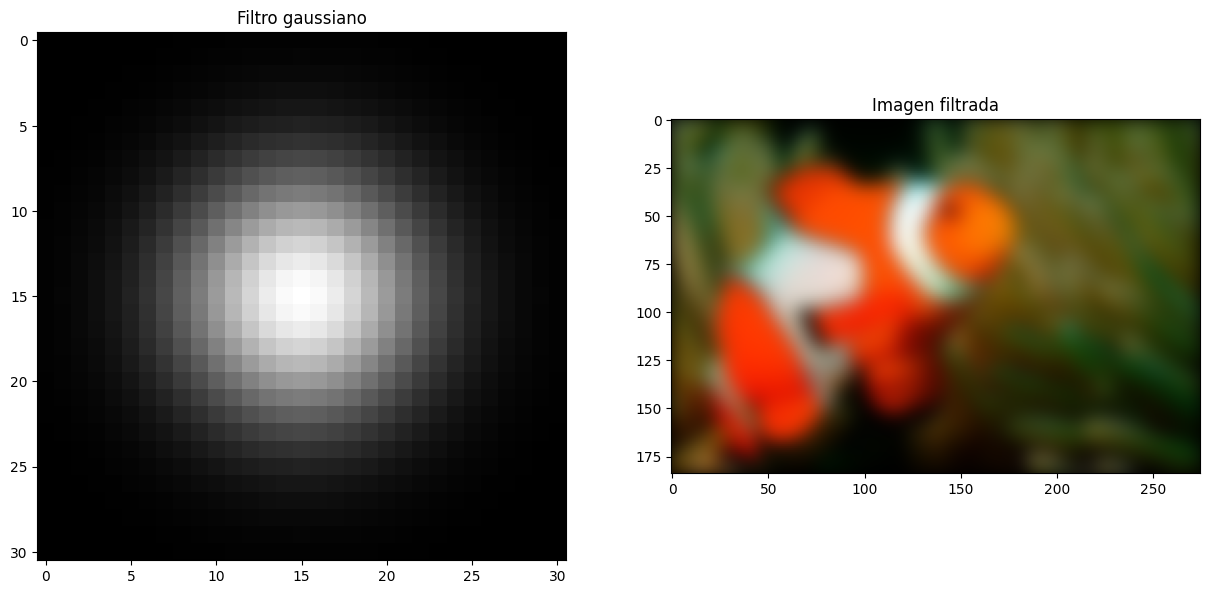

In [12]:
def gaussianBlur(img, sigma, filter_shape):
    
    # creamos el filtro
    gaussian_filter = np.zeros(filter_shape)
    for x in range(filter_shape[0]):
        for y in range(filter_shape[1]):
            gaussian_filter[x, y] = np.exp(-((x - int(filter_shape[0] / 2)) ** 2 + (y - int(filter_shape[1] / 2)) ** 2) / (2 * sigma ** 2))
    gaussian_filter = gaussian_filter / gaussian_filter.sum()

    # aplicamos el filtro
    filtered = convolution(img, gaussian_filter)
    filtered = normalize(filtered)

    return gaussian_filter, filtered


img = imgs[0]
sigma = 5
filter_shape = (31, 31)
gaussian_filter, filtered = gaussianBlur(img, sigma, filter_shape)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(gaussian_filter, cmap='gray')
plt.title('Filtro gaussiano')
plt.subplot(1, 2, 2)
plt.imshow(filtered)
plt.title('Imagen filtrada');

### ¡Ojo! el método Sobel aplica un filtro gaussiano para hacer más blurry la imagen antes de aplicar los filtros derivativos. 
### Implementa una nueva función de edge detection con Sobel que tenga en cuenta esto. Ten en cuenta que la gaussiana se aplica sobre la imagen en escala de grises

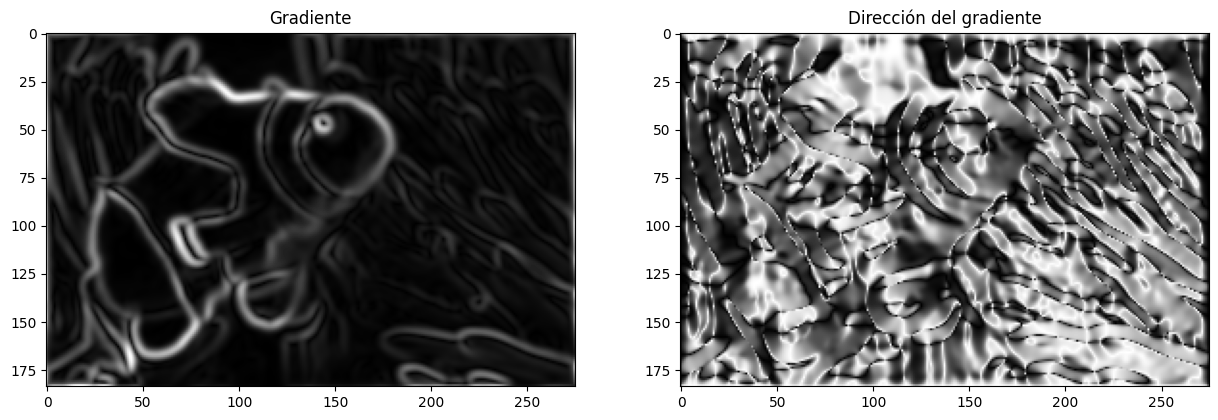

In [13]:
def sobelEdgeDetection(image, sigma, image_format, filter_shape):
    img = togray(image, image_format)
    
    # filtro gaussiano
    filter, filtered = gaussianBlur(img, sigma, filter_shape)

    # filtro sobel
    filter_sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ix, Iy, gradient_magnitude = sobel_edge_detection(filtered, filter_sobel)


    G = np.hypot(Ix, Iy) #Ix e Iy: convolución de los filtros por las filas y columnas (derivadas parciales respecto a X e Y)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return np.squeeze(G), np.squeeze(theta)


img = imgs[0]
sigma = 2
filter_shape = (31,31)
image_format = 'RGB'
G, theta = sobelEdgeDetection(img, sigma, image_format, filter_shape)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(G, cmap='gray')
plt.title('Gradiente')
plt.subplot(1, 2, 2)
plt.imshow(theta, cmap='gray')
plt.title('Dirección del gradiente');


In [14]:
def non_max_suppression(img, theta):
    '''This algorithm is used to convert any gray scale image into its edge image using the non-maximum suppression algorithm.
    This way, we can obtain the local maximum values (sharp edges)
    img: Gradient magnitude matrix
    theta: Gradient direction matrix
    '''
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)

    # converting radians to degree
    angle = theta * 180. / np.pi    # max -> 180, min -> -180
    angle[angle < 0] += 180         # max -> 180, min -> 0

    # Iterating through every pixel of the input except the border pixels
    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255

            # Depending on the angle, identify the neighboring pixels
            # Then, if this pixel's value is less than the neighbors, set it to 0
            # If, on the other hand, it is greater than both neighbors, set it to 255

            # angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                r = img[i, j-1]
                q = img[i, j+1]
            # angle 45
            elif (22.5 <= angle[i, j] < 67.5):
                r = img[i-1, j+1]
                q = img[i+1, j-1]
            # angle 90
            elif (67.5 <= angle[i, j] < 112.5):
                r = img[i-1, j]
                q = img[i+1, j]
            # angle 135
            elif (112.5 <= angle[i, j] < 157.5):
                r = img[i+1, j+1]
                q = img[i-1, j-1]

            if (img[i, j] >= q) and (img[i, j] >= r):
                Z[i, j] = img[i, j]
            else:
                Z[i, j] = 0
    return Z

### teniendo en cuenta los algoritmos ya implementados, Implementa un edge detection con el método canny, el cual es una secuencia de:
###     1. Edge detection con Sobel
###     2. El método NMS (non-maximum suppression) para homogeneizar el grosor de los cantos detectados
    
### Aplica tu método Canny a las imágenes de tu dataset

In [15]:
def cannyEdgeDetection(image, sigma, filter_shape):
    # Turn the image into grayscale
    img = togray(image, 'RGB')
    # Use Gaussian filter to smooth the image
    G,theta = sobelEdgeDetection(image, sigma, image_format, filter_shape)
    # Finally, the image is fed into the non-maximum suppression algorithm.
    img = non_max_suppression(G, theta)
    
    return img

### Aplica la función Canny a la imagen 0 del dataset con un kernel de tamaño 10x10 y sigma de 1.5.

### Juega con estos parámetros hasta encontrar la combinación que detecta los edges mejor. Aplícalo a todo el dataset y rellena el informe con estas pruebas

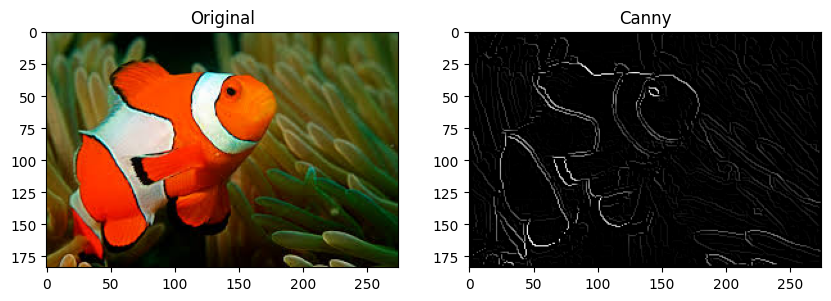

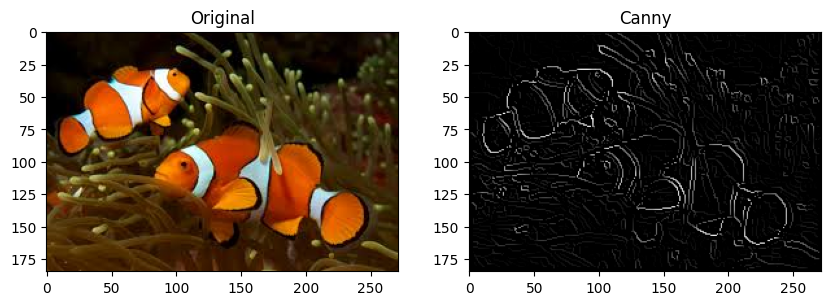

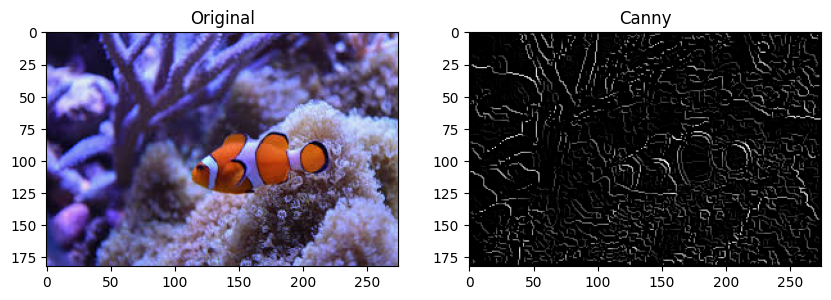

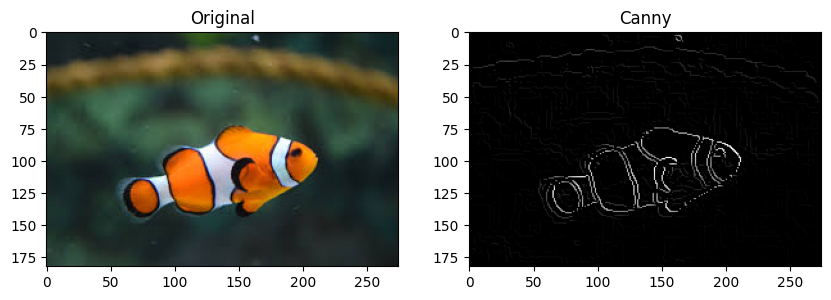

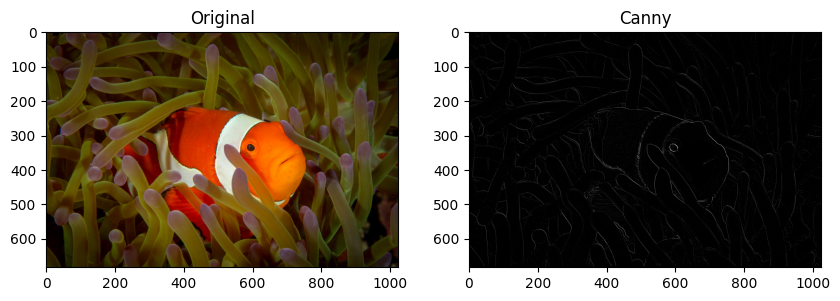

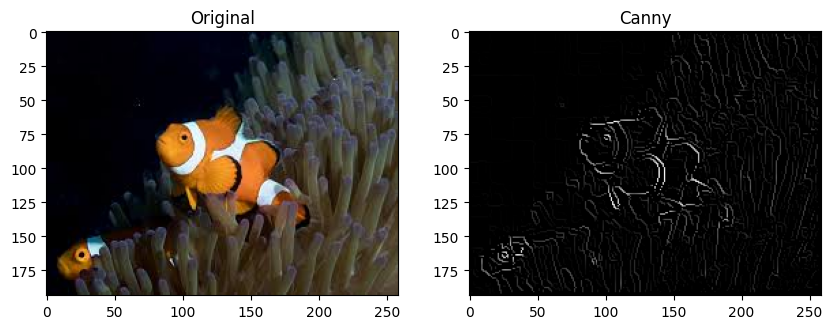

In [16]:
for i in range(0, 6):
    img = imgs[i]
    sigma = 1
    filter_shape = (31,31)
    canny = cannyEdgeDetection(img, sigma, filter_shape)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(canny, cmap='gray')
    plt.title('Canny');

### La librería de python skimage tiene ya implementadas las funciones de:
###     - gaussian
###     - sobel filter
    
### Investiga sobre ellas e implementa un filtro gaussiano y un edge detection con sobel usando los paquetes de skimage. Compara los resultados con los ya obtenidos.

In [17]:
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku

ModuleNotFoundError: No module named 'skimage'

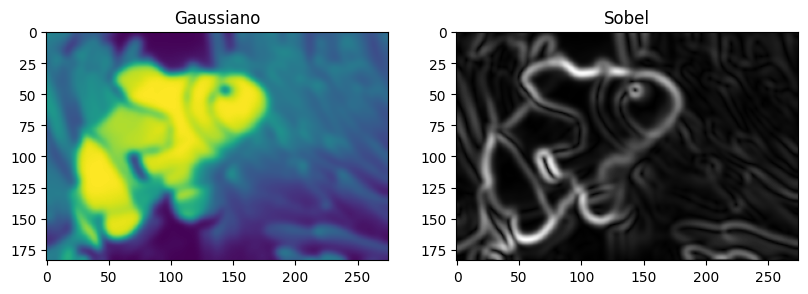

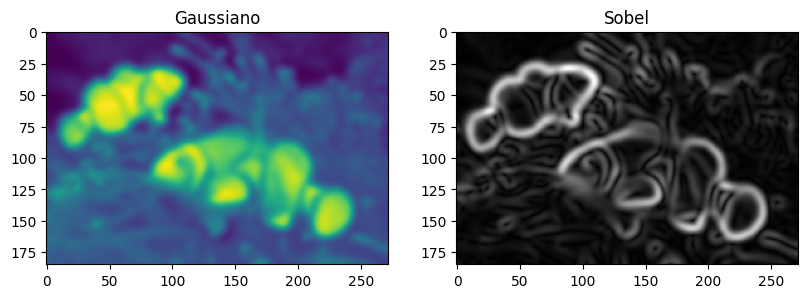

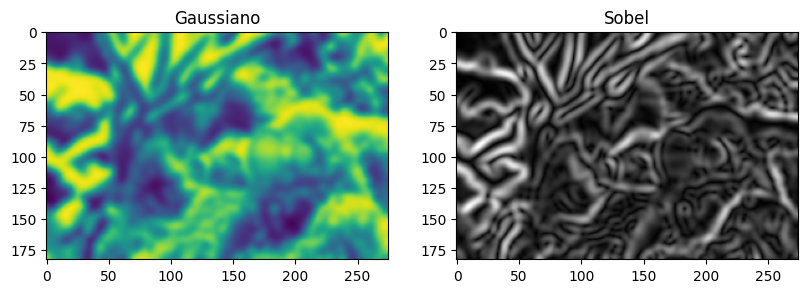

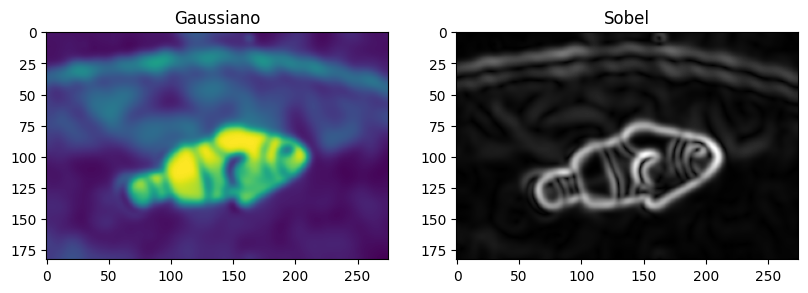

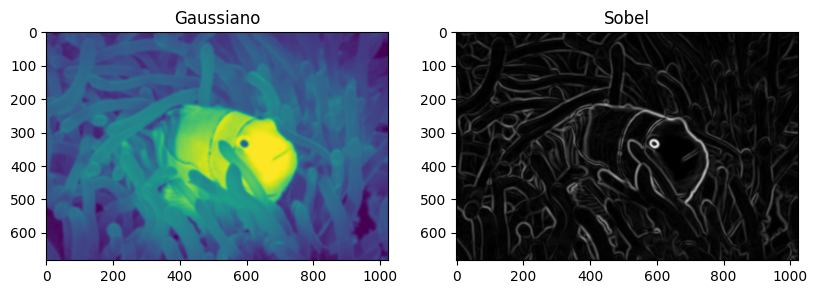

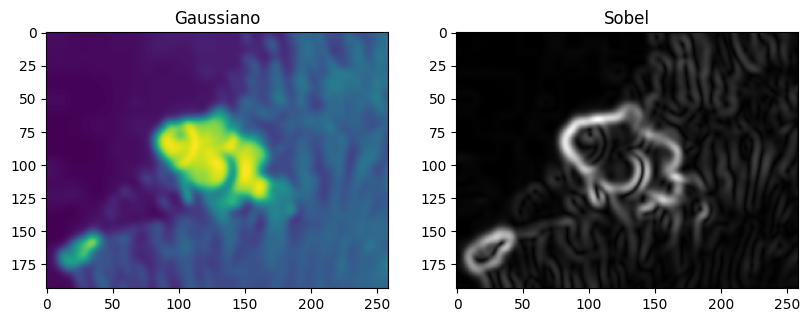

In [ ]:
for i in range(0, 6):
    img = imgs[i]
    img = togray(img, 'RGB')
    sigma = 3
    filter_shape = (31,31)
    gaussian = skif.gaussian(img, sigma=sigma)
    sobel = skif.sobel(gaussian)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(gaussian)
    plt.title('Gaussiano')
    plt.subplot(1, 3, 2)
    plt.imshow(sobel, cmap='gray')
    plt.title('Sobel')

### Implementa los operadores morfológicos: dilation and erosion. Utiliza para ello:

### - La imagen 0 del dataset
### - Un kernel de 3x3 con valores de 255 (blanco) como structuring element

### no olvides binarizar tu imagen antes de aplicar los operadores morfológicos

### Implementa primero la dilatación, muestra los resultados e inclúyelos en el informe 

Text(0.5, 1.0, 'Dilated image')

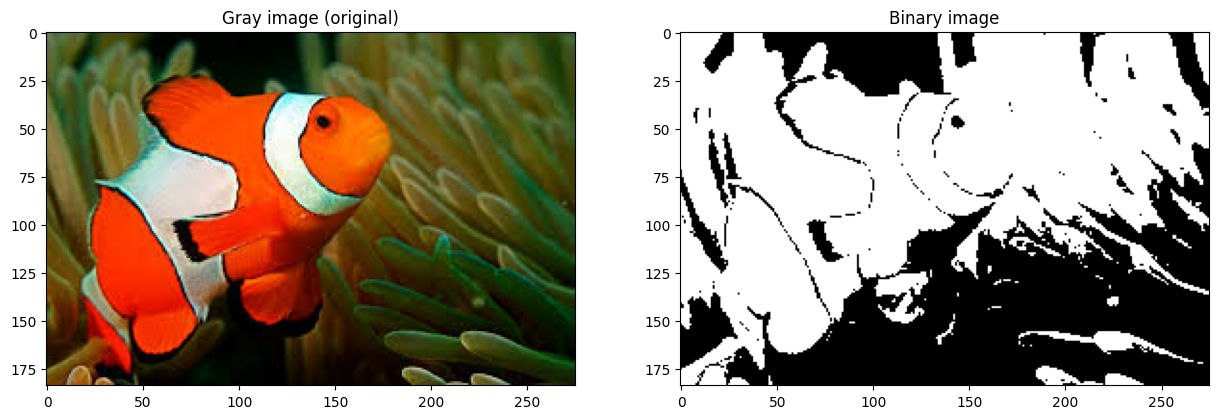

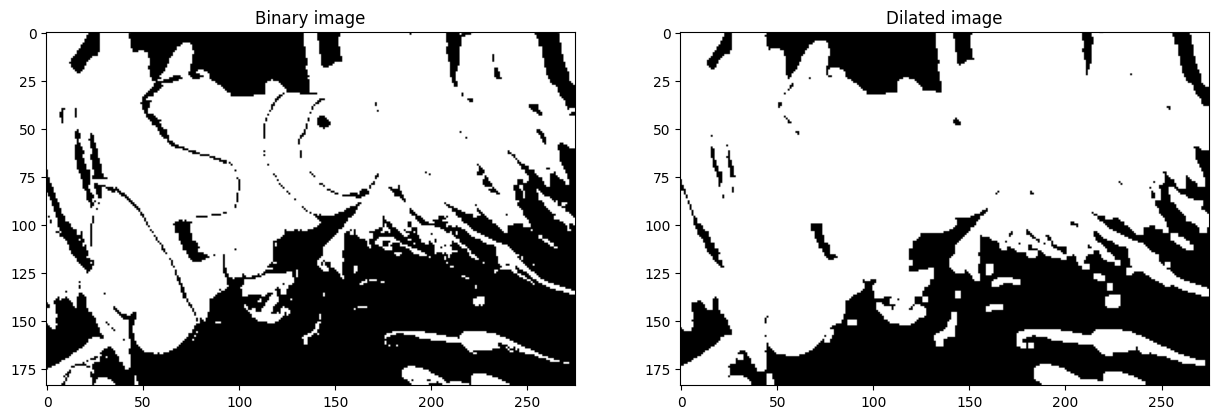

In [45]:
def binary(img):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Tras experimentar con varios valores, hemos decidido que el valor de la cota inferior sea 60
    # Esto es para evitar que sólo se detecten los píxeles muy negros
    cota_inferior = 60
    _, threshold = cv2.threshold(grey, cota_inferior, 255, 0)
    return threshold

def dilate(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    '''Function that uses a 3x3 kernel to dilate the image
    '''
    r, c = img.shape[0], img.shape[1]
    kr, kc = kernel.shape
    # We pad the image
    pad = np.pad(array=img, pad_width=1, mode="constant")

    submatrices = np.array([pad[i:(i + 3), j:(j + 3)]
        for i in range(r) for j in range(c)
    ])    

    # Apply the dilation to the given pixels iterating over the kernel
    dilated = np.array([255 if (i == kernel).any() else 0 for i in submatrices])
    dilated = dilated.reshape((r, c))

    return dilated


img = imgs[0]

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Gray image (original)')

# Convert to binary
img = binary(img)
# add to the plot the image
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.title('Binary image');

# Set up the Kernel and dilate
kernel = np.ones((3, 3)) * 255
img_dilated = dilate(img, kernel)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Binary image')
plt.subplot(1, 2, 2)
plt.imshow(img_dilated, cmap='gray')
plt.title('Dilated image')

### Implementa ahora la erosión, muestra los resultados e inclúyelos en el informe

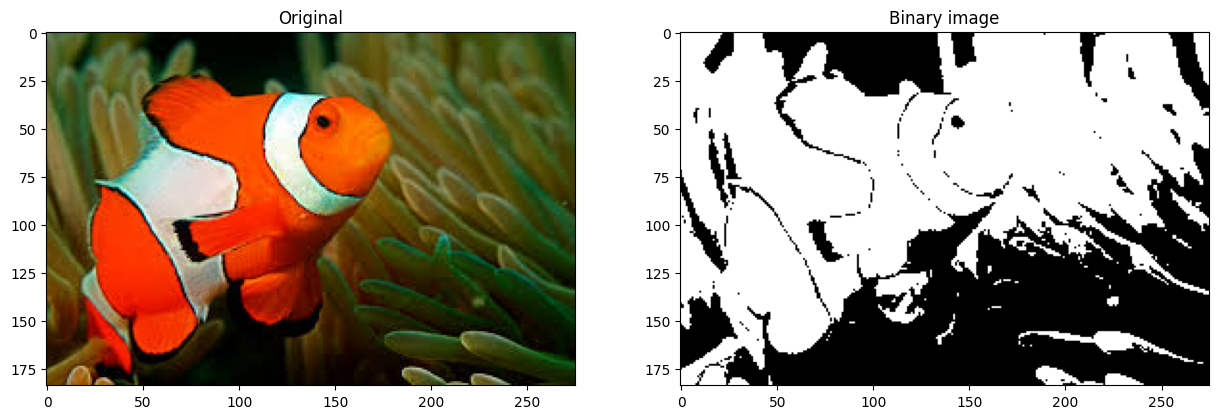

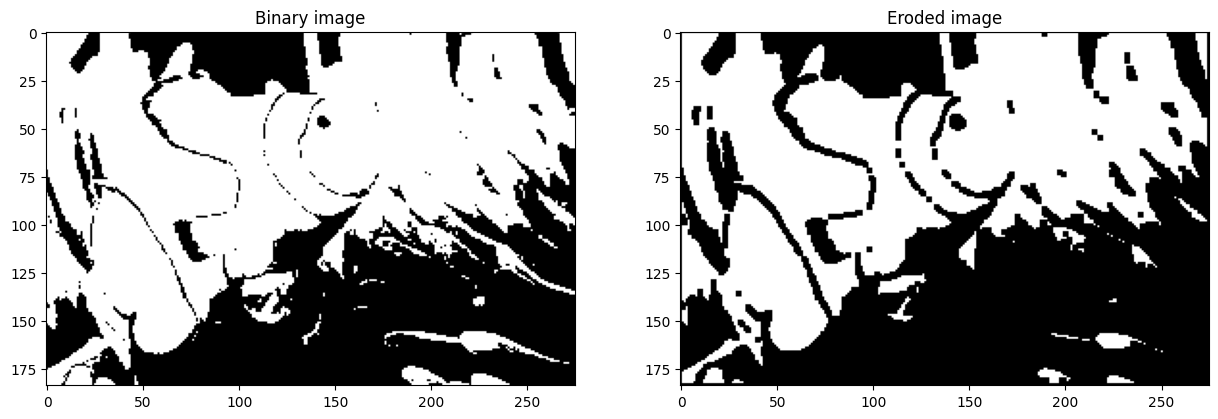

In [48]:
def erosion(img, kernel):
    '''Function that uses a 3x3 kernel to erode the image
    '''
    eroded = np.zeros(img.shape)
    r, c = img.shape[0], img.shape[1]
    kr, kc = kernel.shape
    # We pad the image
    pad = np.pad(array=img, pad_width=1, mode="constant")

    # Again, we must use the sumbatrices to iterate over the image
    submatrices = np.array([pad[i:(i + 3), j:(j + 3)]
        for i in range(r) for j in range(c)
    ])

    # Apply the erosion to the given pixels iterating over the kernel
    eroded = np.array([255 if (i == kernel).all() else 0 for i in submatrices])

    eroded = eroded.reshape((r, c))

    return eroded


img = imgs[0]
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')

# Convert to binary
img = binary(img)
# add to the plot the image
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.title('Binary image');
kernel = np.ones((3, 3)) * 255
img_eroded = erosion(img, kernel)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Binary image')
plt.subplot(1, 2, 2)
plt.imshow(img_eroded, cmap='gray')
plt.title('Eroded image');
